# Model Comparison on Excluded Classes

This notebook compares the performance of a standard object detection model against a hierarchical model on classes that were explicitly excluded from the training dataset.

**Hypothesis:** The hierarchical model will be able to make more informed predictions on unseen classes by leveraging the class hierarchy, predicting a parent or ancestor class instead of failing completely.

**Methodology:**
1.  **Configure Models:** Specify the paths to the model configs and inference results for the models trained with class exclusions.
2.  **Process Data:** Load the prediction results and calculate the hierarchical prediction distribution for each class.
3.  **Select Classes:** Define a list of classes to analyze, focusing on the ones excluded from training.
4.  **Visualize Comparison:** Generate bar charts to compare the prediction distributions of the two models for the selected classes.

## Project Setup

The following cell adds the project's root directory to the Python path to ensure that modules from the `tools` and `hod` directories can be imported.

In [2]:
import sys
import os

# Add project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

os.chdir(project_root)

In [3]:
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mmengine import Config
from mmengine.registry import init_default_scope
from mmdet.registry import DATASETS
from collections import defaultdict
import warnings

# Suppress specific warnings if necessary
warnings.filterwarnings("ignore", category=UserWarning, message=".*Creating a tensor from a list of numpy.ndarrays is slow.*")

# Initialize the default scope for MMDetection
init_default_scope('mmdet')

## 1. Configuration

**Action Required:** Update the `MODELS_TO_ANALYZE` dictionary with the models you wish to compare. The keys should be descriptive names, and the values should be dictionaries containing the paths to the model's configuration file and the inference results (`.pkl` file).

In [28]:
MODELS_TO_ANALYZE = {
    # "DINO-Flat": {
    #     "config": "configs/hod/models/dino/dino-r50_improved_8xb2-36e_aircraft-func.py",
    #     "results_path": "outputs/inference/dino-r50_improved_8xb2-36e_aircraft-func.pkl"
    # },
    "DINO": {
        "config": "configs/hod/models/dino/dino-r50_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64.py",
        "results_path": "outputs/inference/dino-r50_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64.pkl"
    },
    # "DINO-E-Excluded:": {
    #     "config": "configs/hod/models/embedding_dino/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64.py",
    #     "results_path": "outputs/inference/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64.pkl"
    # },
    # "DINO-H (M)": {
    #     "config": "configs/hod/models/hierarchical_dino/hi_dino-r50-hfl10-ecl-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64.py",
    #     "results_path": "outputs/inference/hi_dino-r50-hfl10-ecl-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64-multi.pkl"
    # },
    "DINO-H": {
        "config": "configs/hod/models/hierarchical_dino/hi_dino-r50-hfl10-ecl-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64.py",
        "results_path": "outputs/inference/hi_dino-r50-hfl10-ecl-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64.pkl"
    },
}

## 2. Helper Functions

These functions are imported from the analysis tools to process the raw prediction data.

In [29]:
from tools.analysis_tools.hierarchical_prediction_distribution import (
    calculate_confusion_matrix,
    calculate_hierarchical_prediction_distribution
)

## 3. Data Processing

This section loads the results for each model, calculates the hierarchical statistics per class, and compiles them into a single DataFrame.

In [30]:
all_class_stats = []

for model_name, model_info in MODELS_TO_ANALYZE.items():
    print(f"Processing model: {model_name}...")
    
    config_path = model_info['config']
    results_path = Path(model_info['results_path'])
    
    if not results_path.exists():
        print(f"  WARNING: Results file not found, skipping: {results_path}")
        continue
        
    # Load config and build dataset
    cfg = Config.fromfile(config_path)
    dataset = DATASETS.build(cfg.test_dataloader.dataset)
    
    # Load results
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
        
    # Calculate stats
    confusion_matrix = calculate_confusion_matrix(dataset, results, score_thr=0.3, tp_iou_thr=0.5)
    hierarchical_stats = calculate_hierarchical_prediction_distribution(dataset, confusion_matrix)
    
    # Store stats for each class
    for class_name, stats in hierarchical_stats.items():
        s = stats.copy()
        s['model'] = model_name
        s['class_name'] = class_name
        all_class_stats.append(s)

# Create DataFrame
df_class = pd.DataFrame(all_class_stats)

print("\nProcessing complete.")
if not df_class.empty:
    print("DataFrame created with the following columns:")
    print(df_class.columns)
else:
    print("No data was processed. Please check your `MODELS_TO_ANALYZE` configuration.")

Processing model: DINO...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15696.02img/s]


Processing model: DINO-H...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15039.80img/s]


Processing complete.
DataFrame created with the following columns:
Index(['total_gt', 'tp', 'parent_tp', 'grandparent_tp', 'sibling_tp',
       'cousin_tp', 'ancestor_tp', 'distance', 'fn', 'fp_bg', 'tp_percentage',
       'parent_percentage', 'grandparent_percentage', 'sibling_percentage',
       'cousin_percentage', 'ancestor_percentage', 'fn_percentage',
       'other_class_percentage', 'avg_distance', 'other_class', 'model',
       'class_name'],
      dtype='object')


In [31]:
df_class.head()

,total_gt,tp,parent_tp,grandparent_tp,sibling_tp,cousin_tp,ancestor_tp,distance,fn,fp_bg,...,grandparent_percentage,sibling_percentage,cousin_percentage,ancestor_percentage,fn_percentage,other_class_percentage,avg_distance,other_class,model,class_name
0,2297.0,1426.0,0.0,0.0,168.0,148.0,0.0,0.0,334.0,159.0,...,0.0,7.313888,6.443187,0.0,14.540705,9.621245,0.0,221.0,DINO,Total
1,56.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,...,0.0,0.000000,0.000000,0.0,10.714286,5.357143,0.0,3.0,DINO,A10
2,34.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.000000,0.000000,0.0,8.823529,5.882353,0.0,2.0,DINO,A400M
3,16.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,...,0.0,0.000000,0.000000,0.0,18.750000,6.250000,0.0,1.0,DINO,AG600
4,35.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,13.0,0.0,...,0.0,45.714286,0.000000,0.0,37.142857,17.142857,0.0,6.0,DINO,AH64


## 4. Comparative Visualization

This section generates bar charts to compare the models' performance on specific classes.

### Define Classes for Analysis

**Action Required:** Modify the `CLASSES_TO_PLOT` list to include the class names you want to visualize. These should be the classes that were excluded during training.

In [32]:
CLASSES_TO_PLOT = ['F16', 'Mig29', 'B1', 'C130', 'TB2', 'AH64', 'Total']

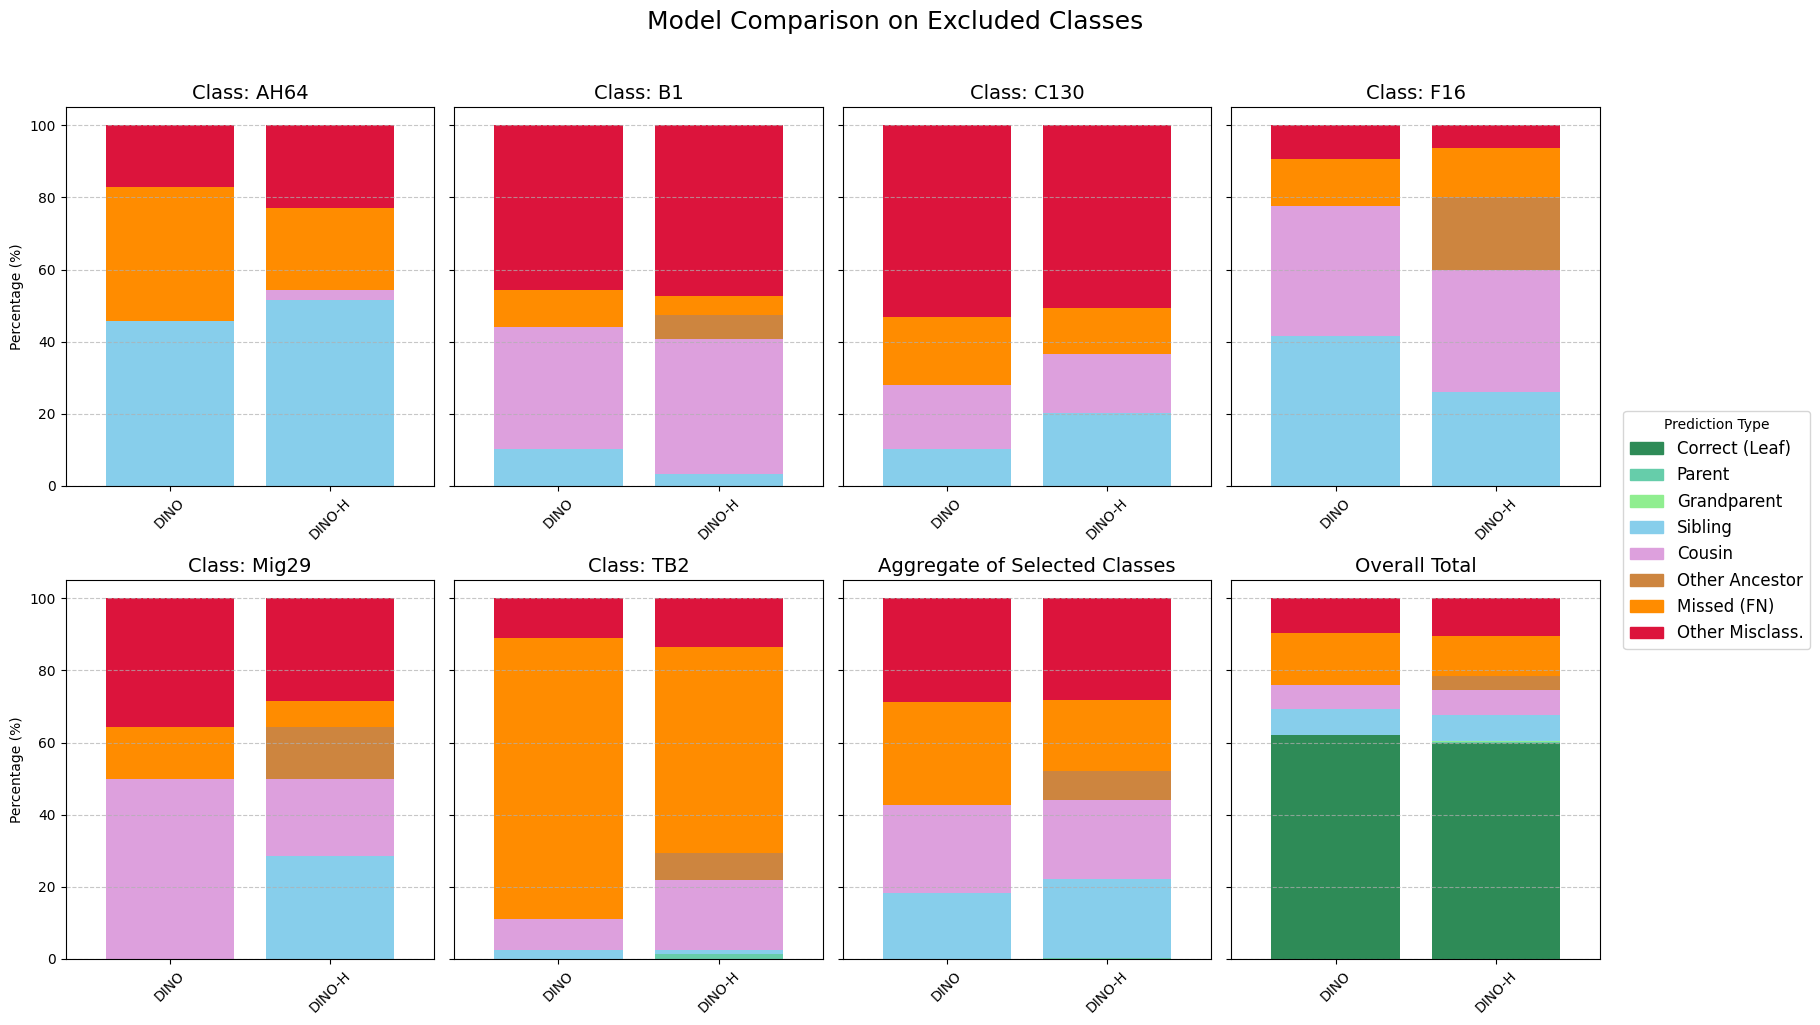

In [33]:
if not df_class.empty:
    # --- Configuration for Plotting ---
    plot_order = [
        'tp_percentage', 
        'parent_percentage', 
        'grandparent_percentage', 
        'sibling_percentage', 
        'cousin_percentage', 
        'ancestor_percentage', 
        'fn_percentage', 
        'other_class_percentage'
    ]
    plot_labels = {
        'tp_percentage': 'Correct (Leaf)',
        'parent_percentage': 'Parent',
        'grandparent_percentage': 'Grandparent',
        'sibling_percentage': 'Sibling',
        'cousin_percentage': 'Cousin',
        'ancestor_percentage': 'Other Ancestor',
        'fn_percentage': 'Missed (FN)',
        'other_class_percentage': 'Other Misclass.',
        'fp_bg': 'FP (Background)'
    }
    plot_colors = {
        'tp_percentage': '#2E8B57', 'parent_percentage': '#66CDAA',
        'grandparent_percentage': '#90EE90', 'sibling_percentage': '#87CEEB',
        'cousin_percentage': '#DDA0DD', 'ancestor_percentage': '#CD853F',
        'fn_percentage': '#FF8C00', 'other_class_percentage': '#DC143C'
    }
    color_list = [plot_colors[p] for p in plot_order]

    # --- Data Preparation for Plotting ---
    
    # 1. Define the classes to analyze and aggregate, excluding 'Total'
    classes_to_analyze = [c for c in CLASSES_TO_PLOT if c != 'Total']
    
    # 2. Define the final plot order: individual classes, then Aggregate, then Total
    final_plot_list = sorted(classes_to_analyze) + ['Aggregate', 'Total']

    # 3. Calculate the aggregate statistics for the selected classes
    df_agg = df_class[df_class['class_name'].isin(classes_to_analyze)].groupby('model')[plot_order].mean().reset_index()
    df_agg['class_name'] = 'Aggregate'

    # 4. Combine the original data with the new aggregate data
    # We select the classes to analyze plus the 'Total' from the original dataframe
    df_plot = pd.concat([df_class[df_class['class_name'].isin(classes_to_analyze + ['Total'])], df_agg])

    # --- Create Stacked Bar Chart ---
    
    # Setup plot grid based on the final list of plots
    num_plots = len(final_plot_list)
    num_cols = 4 # More columns for a compact view
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows), sharey=True)
    axes = axes.flatten()

    for i, class_name in enumerate(final_plot_list):
        ax = axes[i]
        
        # Filter data for the current class or the aggregate view
        df_class_specific = df_plot[df_plot['class_name'] == class_name].copy()
        
        # Set model as index for plotting
        df_to_plot = df_class_specific.set_index('model')[plot_order]

        # Skip plotting if there is no data
        if df_to_plot.empty:
            title = f"Class: {class_name} (No Data)"
            if class_name == 'Aggregate':
                title = "Aggregate View (No Data)"
            ax.set_title(title, fontsize=12)
            ax.set_visible(False)
            continue
        
        # Plot stacked bar with narrower bars
        df_to_plot.plot(kind='bar', stacked=True, ax=ax, color=color_list, legend=False, width=0.8)
        
        # Set title based on whether it's a class, aggregate, or total
        plot_title = f"Class: {class_name}"
        if class_name == 'Aggregate':
            plot_title = "Aggregate of Selected Classes"
        elif class_name == 'Total':
            plot_title = "Overall Total"
        ax.set_title(plot_title, fontsize=14)
        
        ax.set_ylabel("Percentage (%)")
        ax.set_xlabel("") # Model names are on the x-ticks
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        axes[i].set_visible(False)

    # Create a single, shared legend
    handles = [plt.Rectangle((0,0),1,1, color=plot_colors[label]) for label in plot_order]
    legend_labels = [plot_labels[l] for l in plot_order]
    fig.legend(handles, legend_labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=12, title="Prediction Type")

    fig.suptitle('Model Comparison on Excluded Classes', fontsize=18, y=1.02)
    fig.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout for space for legend
    plt.show()

else:
    print("DataFrame is empty. Cannot generate plots.")

### Paper-Ready Plot: Aggregate and Total Comparison

For a more concise presentation suitable for a paper, the following plot focuses only on the two most important views:

1.  **Aggregate of Selected Classes:** Shows the average performance on the specific classes that were excluded from training.
2.  **Overall Total:** Shows the performance across the entire test set, including both seen and unseen classes.

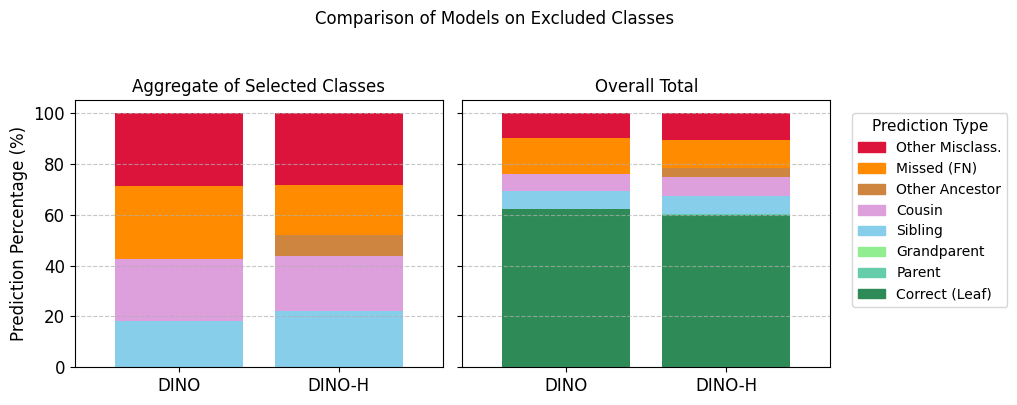

In [34]:
if not df_class.empty:
    # --- Data Preparation for Focused Plot ---
    # We only want to show the Aggregate and Total plots
    focused_plot_list = ['Aggregate', 'Total']
    df_focused = df_plot[df_plot['class_name'].isin(focused_plot_list)].copy()
    
    # Ensure the order is Aggregate, then Total for plotting
    df_focused['class_name'] = pd.Categorical(df_focused['class_name'], categories=focused_plot_list, ordered=True)
    df_focused = df_focused.sort_values('class_name')

    # --- Create Stacked Bar Chart ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    axes = axes.flatten()

    for i, class_name in enumerate(focused_plot_list):
        ax = axes[i]
        df_to_plot = df_focused[df_focused['class_name'] == class_name].set_index('model')[plot_order]

        if df_to_plot.empty:
            ax.set_title(f'{class_name} (No Data)', fontsize=12)
            ax.set_visible(False)
            continue

        df_to_plot.plot(kind='bar', stacked=True, ax=ax, color=color_list, legend=False, width=0.8)
        
        plot_title = f'{class_name} of Selected Classes' if class_name == 'Aggregate' else 'Overall Total'
        ax.set_title(plot_title, fontsize=12)
        ax.set_xlabel("", fontsize=12)
        ax.tick_params(axis='x', rotation=0, labelsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    axes[0].set_ylabel("Prediction Percentage (%)", fontsize=12)
    axes[0].tick_params(axis='y', labelsize=12)

    # --- Create Shared Legend ---
    handles = [plt.Rectangle((0,0),1,1, color=plot_colors[label]) for label in plot_order]
    legend_labels = [plot_labels[l] for l in plot_order]
    
    # Reverse order to match stack
    handles.reverse()
    legend_labels.reverse()
    
    fig.legend(handles, legend_labels, loc='center left', bbox_to_anchor=(0.85, 0.5), title='Prediction Type', fontsize=10, title_fontsize=11)

    fig.suptitle('Comparison of Models on Excluded Classes', fontsize=12, y=1.0)
    fig.tight_layout(rect=[0, 0, 0.85, 0.95]) # Adjust layout for space for legend
    plt.show()

    # --- Prepare Full Data Table ---
    # Use the final_plot_list from the comprehensive plot to order the table
    df_table = df_plot.copy()
    df_table['class_name'] = pd.Categorical(df_table['class_name'], categories=final_plot_list, ordered=True)
    df_table = df_table.sort_values(['class_name', 'model'])

else:
    print("DataFrame is empty. Cannot generate plots.")

### Data Table for Analysis

The table below contains the complete data used for the analysis, including each excluded class, the aggregate view, and the overall total.

In [27]:
if 'df_table' in locals() and not df_table.empty:
    display(df_table.set_index(['class_name', 'model']).rename(columns=plot_labels))
else:
    print("No data to display. Please run the plotting cell first.")

total_gt      tp  parent_tp  grandparent_tp  \
class_name model                                                     
AH64       DINO            35.0     0.0        0.0             0.0   
           DINO-H (M)      35.0     0.0        0.0             0.0   
           DINO-H (S)      35.0     0.0        0.0             0.0   
B1         DINO            59.0     0.0        0.0             0.0   
           DINO-H (M)      59.0     0.0        0.0             0.0   
           DINO-H (S)      59.0     0.0        0.0             0.0   
C130       DINO            79.0     0.0        0.0             0.0   
           DINO-H (M)      79.0     0.0        0.0             0.0   
           DINO-H (S)      79.0     0.0        0.0             0.0   
F16        DINO           130.0     0.0        0.0             0.0   
           DINO-H (M)     130.0     0.0        1.0             0.0   
           DINO-H (S)     130.0     0.0        0.0             0.0   
Mig29      DINO            14.0     0.0        0.0             0.0   
           DINO-H (M)      14.0     0.0        0.0             0.0   
           DINO-H (S)      14.0     0.0        0.0             0.0   
TB2        DINO            82.0     0.0        0.0             0.0   
           DINO-H (M)      82.0     0.0        2.0             0.0   
           DINO-H (S)      82.0     0.0        1.0             0.0   
Aggregate  DINO             NaN     NaN        NaN             NaN   
           DINO-H (M)       NaN     NaN        NaN             NaN   
           DINO-H (S)       NaN     NaN        NaN             NaN   
Total      DINO          2297.0  1426.0        0.0             0.0   
           DINO-H (M)    2297.0  1425.0        3.0             6.0   
           DINO-H (S)    2297.0  1377.0        6.0             2.0   

                       sibling_tp  cousin_tp  ancestor_tp  distance     fn  \
class_name model                                                             
AH64       DINO              16.0        0.0          0.0       0.0   13.0   
           DINO-H (M)        20.0        2.0          0.0       0.0    8.0   
           DINO-H (S)        18.0        1.0          0.0       0.0    8.0   
B1         DINO               6.0       20.0          0.0       0.0    6.0   
           DINO-H (M)         4.0       23.0          2.0      10.0    3.0   
           DINO-H (S)         2.0       22.0          4.0      20.0    3.0   
C130       DINO               8.0       14.0          0.0       0.0   15.0   
           DINO-H (M)        16.0       13.0          0.0       0.0   10.0   
           DINO-H (S)        16.0       13.0          0.0       0.0   10.0   
F16        DINO              54.0       47.0          0.0       0.0   17.0   
           DINO-H (M)        42.0       55.0          9.0      46.0   16.0   
           DINO-H (S)        34.0       44.0         26.0     130.0   18.0   
Mig29      DINO               0.0        7.0          0.0       0.0    2.0   
           DINO-H (M)         4.0        4.0          1.0       5.0    1.0   
           DINO-H (S)         4.0        3.0          2.0      10.0    1.0   
TB2        DINO               2.0        7.0          0.0       0.0   64.0   
           DINO-H (M)         0.0       16.0          3.0      14.0   47.0   
           DINO-H (S)         1.0       16.0          6.0      25.0   47.0   
Aggregate  DINO               NaN        NaN          NaN       NaN    NaN   
           DINO-H (M)         NaN        NaN          NaN       NaN    NaN   
           DINO-H (S)         NaN        NaN          NaN       NaN    NaN   
Total      DINO             168.0      148.0          0.0       0.0  334.0   
           DINO-H (M)       178.0      182.0         34.0     179.0  240.0   
           DINO-H (S)       167.0      164.0         88.0     436.0  250.0   

                       FP (Background)  Correct (Leaf)    Parent  Grandparent  \
class_name model                                                                
AH64       